# Install Packages
We first install the packages required for this notebook. Unfortunately because of the way pip and jupyter works after running the following commands a restart of the kernel/runtime is necessary.

In [ ]:
!pip install -e ../Environments
!pip install matplotlib

# <span style="color:red">Restart the kernel</span>

# Required Imports

In [1]:
# for using the env that we built
import gym
# for number crunching and storing results
import numpy as np

# plotting the graphs
from matplotlib import pyplot as plt

# Seed for this environment

In [2]:
np.random.seed(1)

# Policy and the helping function to sample action 

In [3]:
# policy, given state pmf for actions
right_policy = { 1 : [ 1.0, 0.0 ],
           2 : [ 1.0, 0.0 ],
           3 : [ 1.0, 0.0 ],
           4 : [ 1.0, 0.0  ],
           5 : [ 1.0, 0.0  ]
           }

left_policy = { 1 : [ 0.0, 1.0 ],
           2 : [ 0.0, 1.0 ],
           3 : [ 0.0, 1.0 ],
           4 : [ 0.0, 1.0  ],
           5 : [ 0.0, 1.0  ]
           }



# helping function to take action given a policy and state
def take_action(pi, observation ):
    return np.random.choice([0,1], 1, p = pi[observation], replace=True)

# generateTrajectory function(2.1)

In [4]:
# function to generate samples of trajectory given dynamics function and policy
def generateTrajectory(env, pi, maxSteps):
    trajectory = []

    # starting the trajectory
    last_state = env.reset()
    is_terminal = False
    for i in range (maxSteps):
        action = take_action(pi, last_state)
        next_state , reward, is_terminal, _ = env.step(action)

        trajectory.append((last_state, int(action), reward, next_state))

        # if the agent completes before, just break
        if is_terminal:
            break#return


        last_state = next_state
    # won't consider the trajectories that went beyond maxsteps, assuming the agent has been trapped
    # and this trajectory is not important now.
    if is_terminal == True:
        return tuple(trajectory)

# decayAlpha function(2.2)

In [5]:
# decay type, can exponential and linear
decay_type_dict = {"Exp":0, "Lin":1}

# function to generate decaying alpha values for the number of episodes
def decayAlpha(initialValue, finalValue, maxSteps, decayType = decay_type_dict["Exp"]):

    # exponential lamda parameter, try playing with this parameter
    lamda = 0.03

    # for generating the next decayed alpha
    def generateAlpha( t, param = lamda ):
        if decayType == decay_type_dict["Exp"]:
            return (initialValue-finalValue)*np.exp(-t*param) + finalValue

        elif decayType == decay_type_dict["Lin"]:
            return ((finalValue - initialValue)*t + maxSteps*initialValue)/maxSteps

    alpha_values = []

    for i in range(maxSteps):
        alpha_values.append( generateAlpha(i) )

    return alpha_values

# Plotting trend for decayAlpha(2.2)

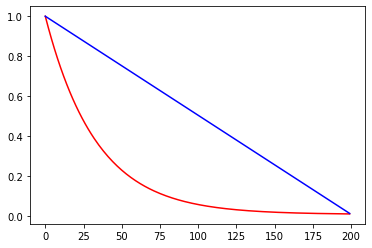

In [6]:
alpha_values_exp = decayAlpha(1, 0.01, 200, decayType=decay_type_dict["Exp"] )

    #plt.plot(alpha_values)

alpha_values_lin = decayAlpha(1, 0.01, 200, decayType=decay_type_dict["Lin"] )

plt.figure(0)
plt.plot(alpha_values_exp, color= 'r', label= "Exponential Decay")
plt.plot(alpha_values_lin, color = 'b', label = "Linear")



# TemporalDifferencePrediction(2.4)

In [10]:
def TemporalDifferencePrediction(env, pi,  num_episodes = 500, gamma= 0.99):
    # for storing the target values of state three ie the return value
    target_values_for_state_three = []

    # required bookkeeping arrays for checking out the trends followed ,and their population
    v = []
    v_r = []
    num_states = 7

    for i in range(0, num_states):
        v.append(0)

    # need alphas for all episodes using the certain criteria given in the question, consider changing exponential to linear
    # for fun
    alpha_values = decayAlpha(0.5, 0.01, int(num_episodes / 2), decay_type_dict["Exp"])
    alpha_values = np.array(alpha_values + int((num_episodes / 2)) * [0.01])

    # if you would like to see what trend is followed by alpha while decaying
    plt.figure(0)
    plt.plot(alpha_values)

    # for every step in every update, do td, computing guess from another guess
    for n in range(num_episodes):
        alpha = alpha_values[n]

        # starting the trajectory
        last_state = env.reset()
        is_terminal = False
        while is_terminal == False:
            action = take_action(pi, last_state)
            next_state, reward, is_terminal, _ = env.step(action)

            # td target, error and update
            td_target = reward + gamma*v[next_state]
            td_error = td_target - v[last_state]
            v[last_state] = v[last_state] + alpha*td_error

            if last_state == 3:
                target_values_for_state_three.append(td_target)

            last_state = next_state


        # append to store the running values so that later we can see the trend
        v_r.append(np.array(v).copy())

    return np.array(v), np.array(v_r), np.array(target_values_for_state_three)

# TestingcTDPrediction(2.4)
the perfect way to test this here is first we compute optimal values of states, and than compare these values with values predicted by Prediction algo. 

# True State values for Right Policy
Kindly consider referring to lecture-4 slides to see how we computed below matrix.

In [11]:
 gamma = 0.99
# solving the policy
A = np.array([[1, 0, 0, 0, 0, 0, 0],
    [0, -1, 0.5*gamma, 0, 0, 0, 0],
    [0, 0.5*gamma, -1, 0.5*gamma, 0, 0 ,0],
    [0, 0, 0.5*gamma, -1, 0.5*gamma, 0, 0],
    [0, 0, 0, 0.5*gamma, -1, 0.5*gamma, 0],
    [0, 0, 0, 0, 0.5*gamma, -1, 0 ],
    [0, 0, 0, 0, 0, 0, 1]])

b = np.array([[0], [0], [0], [0],[0], [-0.5], [0]])

# solution for left policy as well as right policy
v_sol = np.linalg.solve(A, b)
    
v_sol = v_sol.flatten()
print("optimal solution:\n[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :")
print(v_sol)

optimal solution:
[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :
[0.         0.15008431 0.30320062 0.4624422  0.63102605 0.81235789
 0.        ]


# Computing state values using TD(2.4)
You will see that the values are really close to the optimal solution, later this will become more 
clear when we will put graphs

estimated solution(TD):
[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :
[0.         0.13623736 0.2834685  0.44357513 0.61179069 0.80318691
 0.        ]
optimal solution:
[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :
[0.         0.15008431 0.30320062 0.4624422  0.63102605 0.81235789
 0.        ]


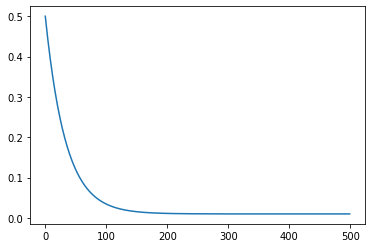

In [13]:
env_name = "environments:random_walk_env-v0"

env = gym.make(env_name)

num_episodes = 500
max_steps = 30


# TD
v_comp_right_TD, running_values_right_TD, target_values_TD =  TemporalDifferencePrediction(env, right_policy, num_episodes, gamma)
# v_comp_left = MonteCarloPrediction(env, left_policy, 20, 500, True, gamma)
print("estimated solution(TD):\n[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :")
print(v_comp_right_TD)

print("optimal solution:\n[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :")
print(v_sol)

# Compute average to reduce variance
These values are little off to the real values, lets compute an average of some number of computations so that the noise is effectively averaged out.

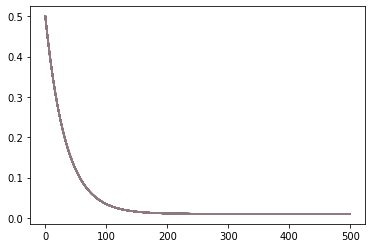

In [14]:
num = 50

for i in range(2, num):
    td_value, running_TD, target_TD = TemporalDifferencePrediction(env, right_policy, num_episodes, gamma)
    
    
    v_comp_right_TD += (td_value - v_comp_right_TD)/i
    min_len = min(running_TD.shape[0], running_values_right_TD.shape[0])
    running_values_right_TD[:min_len, :] += (running_TD[:min_len, :] - running_values_right_TD[:min_len, :])/i
    #min_len = min(target_TD.shape[0], target_values_TD.shape[0])
    #print(min_len)
    #target_values_TD[:min_len] += (target_TD[:min_len] - target_values_TD[:min_len])/i

# TD estimate of each non-terminal state of RWE ( 2.10)

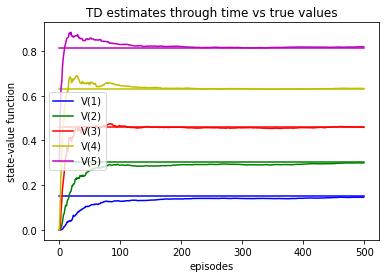

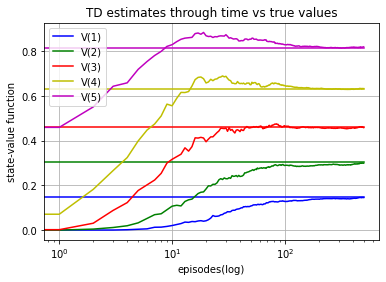

In [17]:
plt.figure(7)
plt.title("TD estimates through time vs true values")
plt.ylabel("state-value function")
plt.xlabel("episodes")

plt.plot([v_sol[1]] * num_episodes, color='b')
plt.plot([v_sol[2]] * num_episodes, color='g')
plt.plot([v_sol[3]] * num_episodes, color='r')
plt.plot([v_sol[4]] * num_episodes, color='y')
plt.plot([v_sol[5]] * num_episodes, color='m')

plt.plot(running_values_right_TD[:, 1:2], color='b', label='V(1)')
plt.plot(running_values_right_TD[:, 2:3], color='g', label='V(2)')
plt.plot(running_values_right_TD[:, 3:4], color='r', label='V(3)')
plt.plot(running_values_right_TD[:, 4:5], color='y', label='V(4)')
plt.plot(running_values_right_TD[:, 5:6], color='m', label='V(5)')
plt.legend()

plt.figure(8)
plt.title("TD estimates through time vs true values")
plt.ylabel("state-value function")
plt.xlabel("episodes(log)")

plt.plot([v_sol[1]] * num_episodes, color='b')
plt.plot([v_sol[2]] * num_episodes, color='g')
plt.plot([v_sol[3]] * num_episodes, color='r')
plt.plot([v_sol[4]] * num_episodes, color='y')
plt.plot([v_sol[5]] * num_episodes, color='m')

plt.plot(running_values_right_TD[:, 1:2], color='b',
             label='V(1)')
plt.plot(running_values_right_TD[:, 2:3], color='g',
             label='V(2)')
plt.plot(running_values_right_TD[:, 3:4], color='r',
             label='V(3)')
plt.plot(running_values_right_TD[:, 4:5], color='y',
             label='V(4)')
plt.plot(running_values_right_TD[:, 5:6], color='m',
             label='V(5)')

plt.xscale('log')
plt.grid()
plt.legend()


# Target Value Graphs for TD ( 2.14)

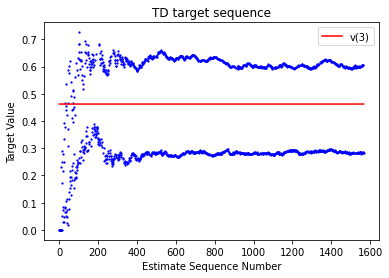

In [18]:

plt.figure(9)
plt.title("TD target sequence")
plt.ylabel("Target Value")
plt.xlabel("Estimate Sequence Number")
plt.plot(np.array(range(len(target_values_TD))), [v_sol[3]]*len(target_values_TD), color='r', label = "v(3)")
plt.scatter(np.array(range(len(target_values_TD))), target_values_TD, color='b', s=1.5)
plt.legend()

